In this notebook, we implement a more automatic simulation for the fly. After setting up all what is needed, the simulation is launched and it will end once the time allowed for the simulation has passed. The trajectory of the fly is later plotted.

In [5]:
import numpy as np
import os
from pathlib import Path
import logging
from flygym.mujoco.arena import OdorArena
import matplotlib.pyplot as plt
from flygym.mujoco import Parameters
from flygym.mujoco.examples.turning_controller import HybridTurningNMF

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[24, 0, 1.5], [8, -4, 1.5]])  # , [16, 4, 1.5]])

# Peak intensities: array of shape (num_odor_sources, odor_dimesions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case attractive). If it's (0, x) then it's in the 2nd dimension (in this case
# aversive)
peak_intensity = np.array([[1, 0], [0, 1]])  # , [0, 1]])

odor_dimesions = len(peak_intensity[0])

# The reward assigned to each source
odor_valence = [10, 2]

logging.basicConfig(level=logging.INFO)

In [6]:
# Set up the arena
arena = OdorArena(
    odor_source=odor_source,
    peak_intensity=peak_intensity,
    odor_valence=odor_valence,
    diffuse_func=lambda x: x**-2,
    marker_size=0.3,
)

(-0.5, 799.5, 607.5, -0.5)

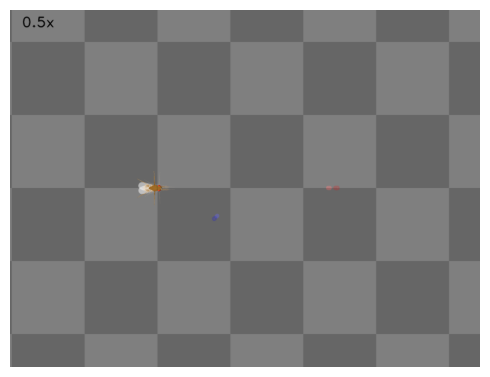

In [7]:
# Add the NeuroMechFly
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
    simulation_time=10,
)
for i in range(1):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("off")
#fig.savefig("./outputs/olfaction_env.png")

In [8]:
# Print the actual time before the start of the simulation
print(sim.curr_time)

0.0001


In [9]:
# Set up for the simulation
decision_interval = 0.05
run_time = sim.simulation_time
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)

obs_hist = []
odor_history = []
obs, _ = sim.reset()

In [10]:
# Actual simulation
obs_hist = arena.run_odor_taxis_simulation(
    sim,
    num_decision_steps,
    obs,
    physics_steps_per_decision_step,
    obs_hist,
    odor_history,
)

 17%|█▋        | 34/200 [03:55<19:09,  6.92s/it]


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# Choose a name to save both the video and the trajectory
name = "random_simulation"
path = Path(f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}")
os.mkdir(path)

In [ ]:
# Plot the fly trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
# ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:blue", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-10, 10)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
# save the trajectory
fig.savefig(f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_trajectory.png")

In [ ]:
# Save the video
sim.save_video(f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_video.mp4"
)